In [15]:
from DeepPurpose import utils, dataset
from sklearn.model_selection import train_test_split
from DeepPurpose.utils import *

import torch
import numpy as np
from AutoEncoder import AutoEncoder
from torch.utils.data import DataLoader, Dataset
from torch import nn
import random

from tqdm import tqdm

from torch.utils.data import SequentialSampler
from torch.utils import data as torch_data

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import plotly.express as px

# Load the protein sequence features

In [2]:
branch_model_to_use = 'protein'
drug_encoding = 'MPNN'
target_encoding = 'CNN'

wandb_project_name = 'Protein_autoencoder'
wandb_project_entity = 'diliadis'

X_drugs, X_targets, y = dataset.load_process_DAVIS(path = './data', binary = False, convert_to_log = True, threshold = 30) # http://staff.cs.utu.fi/~aatapa/data/DrugTarget/
drug_encoding, target_encoding = drug_encoding, target_encoding
print('Processing the dataset...')
train, _, _ = utils.data_process(X_drugs, X_targets, y, 
                            drug_encoding, target_encoding, 
                            split_method='random',frac=[0.7,0.1,0.2],
                            random_seed = 1)
print('Done! ')

# get the feature representations of the unique drugs or proteins
data = train.drop_duplicates('SMILES' if branch_model_to_use=='drug' else 'Target Sequence', ignore_index=True)['SMILES' if branch_model_to_use=='drug' else 'target_encoding']


Beginning Processing...
Beginning to extract zip file...
Default set to logspace (nM -> p) for easier regression
Done!
Processing the dataset...
Drug Target Interaction Prediction Mode...
in total: 30056 drug-target pairs
encoding drug...
unique drugs: 68
encoding protein...
unique target sequence: 379
splitting dataset...
Done.
Done! 


# Load the pretrained model

In [3]:
with open("results/15_11_2022__09_56_19/config.pkl", "rb") as file_to_read:
    config = pickle.load(file_to_read)
    
# inialize the model
model = AutoEncoder(config)

model.load_pretrained("results/15_11_2022__09_56_19/model.pt", model.device)

# model.train(train, val, test)

Using the following device: cuda:7
Early stopping detected metric: loss


In [16]:
def generate_embeddings(model, data, config, branch_model_to_use='protein'):
    
    model.model = model.model.to(model.device)
    
    if data is not None:
        
        data = data.drop_duplicates('SMILES' if branch_model_to_use=='drug' else 'Target Sequence', ignore_index=True)
        
        info = data_process_loader(data.index.values, data.Label.values, data, **config)
        params = {'batch_size': config['batch_size'],
                'shuffle': False,
                'num_workers': config['num_workers'],
                'drop_last': False,
                'sampler':SequentialSampler(info)}

        data_generator = torch_data.DataLoader(data_process_loader(data.index.values, data.Label.values, data, **config), **params)


    model.model.eval()
    scores = []
    for i, (v_d, v_p, label) in enumerate(tqdm(data_generator)):
        v_p = v_p.double().to(model.device)     
        
        score = model.model.encoder(v_p)
        
        for emb in score.detach().cpu().numpy():
            scores.append(emb.flatten())
    return scores

In [17]:
protein_embeddings = generate_embeddings(model, train, config, branch_model_to_use='protein')

100%|██████████| 12/12 [00:00<00:00, 14.57it/s]


In [18]:
protein_embeddings[0].shape

(7960,)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 379 samples in 0.003s...
[t-SNE] Computed neighbors for 379 samples in 0.066s...
[t-SNE] Computed conditional probabilities for sample 379 / 379
[t-SNE] Mean sigma: 22.024330
[t-SNE] KL divergence after 250 iterations with early exaggeration: 66.228439
[t-SNE] KL divergence after 1000 iterations: 0.471736


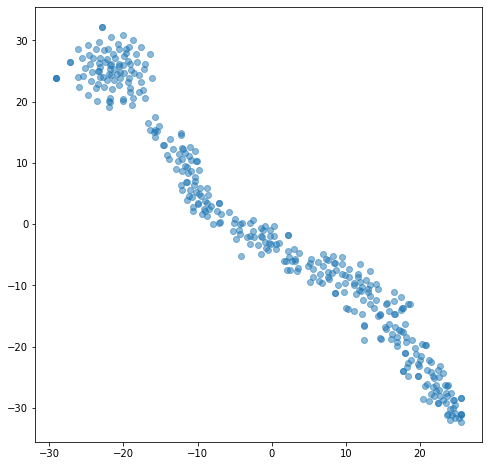

In [20]:
# Create a two dimensional t-SNE projection of the embeddings
tsne_protein = TSNE(2, verbose=1)
tsne_proj_protein = tsne_protein.fit_transform(protein_embeddings)
# Plot those points as a scatter plot and label them based on the pred labels
# cmap = cm.get_cmap('tab20')

# num_categories = 10
# for lab in range(num_categories):
#     indices = test_predictions==lab

fig, ax = plt.subplots(figsize=(8,8))
ax.scatter(tsne_proj_protein[:, 0],tsne_proj_protein[:,1], alpha=0.5)
# ax.legend(fontsize='large', markerscale=2)
plt.show()